In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

\[ \frac{dS}{dt} = - \beta SI - xS \]

\[ \frac{dIM}{dt} = xS \]

\[ \frac{dI}{dt} = \beta SI - \gamma I \]

\[ \frac{dR}{dt} = \gamma I \]

\[ x = \delta \frac{I}{IM} \]

\[ \frac{dS}{dt} = -SI(\beta + \frac{\delta}{IM}) \]

\[ \frac{dIM}{dt} = \delta \frac{SI}{IM}  \]

\[ \frac{dI}{dt} = \beta SI - \gamma I \]

\[ \frac{dR}{dt} = \gamma I \]

In [5]:
def analytical_model():
    max_season = 1000
    tmax = 1000
    i0 = 0.005
    fim0 = 0.1
    r0 = 0
    s0 = 1-i0-fim0
    beta = 0.83
    gamma = 1/3
    kappa = 0.1
    delta = 1
    result = pd.DataFrame({'Cr':  [], 
                           'FES': [], 
                           'Fim': [],
                           'Fpv': [],
                           'SAP': []})
    
    for cr in np.arange(0, 1.1, 0.1):
        fpv_hist = [fim0]
        for season in range(max_season):
            fs, fi, fr = s0, i0, r0
            if season == 0:
                fim = fim0
                
            for t in range(tmax):
                next_fs = fs - fs * fi * (beta + delta/fim)
                next_fim = fim + delta * fs * fi / fim
                next_fi = fi + beta * fs * fi - gamma * fi
                next_fr = fr + gamma * fi
                fs, fim, fi, fr = next_fs, next_fim, next_fi, next_fr
                
                if fi == 0:
                    break
            
            next_fpv = fpv_hist[-1] - ( fpv_hist[-1]/(1+np.exp(-cr/kappa)) - fs/(1+np.exp(cr/kappa)) ) - ( (2*fpv_hist[-1]-1)/2 ) - ( fpv_hist[-1]/(1+np.exp((-cr+1)/kappa) ) - fr/(1+np.exp((cr-1)/kappa)) )
            fpv_hist.append(next_fpv)
            
            if season >= 100 and np.mean(fpv_hist[season-100:season-1]) - fpv_hist[-1] < 0.001:
                FPV = np.mean(fpv_hist[season-99:season])
                break
        
        if not FPV:
            FPV = np.mean(fpv_hist[season-99:season])
        
        SAP = -cr * fim -1 * fr
        new_result = pd.DataFrame([[format(cr,'.1f'), fr, fim, FPV, SAP]], columns=['Cr', 'FES', 'Fim', 'Fpv', 'SAP'])
        result = result.append(new_result)

    return result

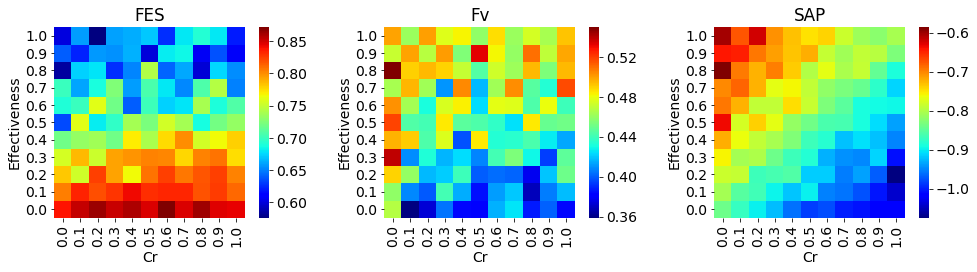

In [21]:
# 前のMASのモデルでの結果
df = pd.read_csv("result1.csv")
fig = plt.figure(figsize=(14, 4))
plt.rcParams['font.size'] = 14
for index, value in enumerate(["FES", "VC", "SAP"]):
    fig.add_subplot(1, 3, index+1)
    """
    if value in ["FES", "VC"]:
        vmin = 0
        vmax = 1
    else:
        vmin = -1.1
        vmax = 0
    """
    title = value
    if value == "VC":
        title = "Fv"
    
    pivot = df.pivot("Effectiveness", "Cr", value)
    sns.heatmap(pivot, cmap='jet', square=True)
    plt.title(title)
    plt.gca().invert_yaxis()
    # plt.xticks(rotation='horizontal')
    plt.tight_layout()
fig.savefig('single_episode.png')

In [6]:
def single_episode_plot(save=False):
    df = pd.read_csv("src/result1_delta_0.1.csv")
    x = df.Cr
    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(16, 12))
    fig.add_subplot(221)
    plt.scatter(x = x, y = df.FES)
    plt.title("FES")
    plt.ylim(0, 1)
    plt.xlabel("Cr")

    fig.add_subplot(222)
    plt.scatter(x = x, y = df.Fim)
    plt.title("Fim")
    plt.ylim(0, 1)
    plt.xlabel("Cr")

    fig.add_subplot(223)
    plt.scatter(x = x, y = df.Fpv)
    plt.title("Fpv")
    plt.ylim(0, 1)
    plt.xlabel("Cr")

    fig.add_subplot(224)
    plt.scatter(x = x, y = df.SAP)
    plt.title("SAP")
    plt.ylim(-1, 0)
    plt.xlabel("Cr")

    plt.suptitle("δ = 1.0", y = 1)
    plt.tight_layout()

    if save == True:
        fig.savefig("result(δ=1.0).png", bbox_inches="tight")

    plt.show()

In [ ]:
single_episode_plot()

In [18]:
# graph_for = "FES", Fim", "Fpv", "SAP"
def various_delta_plot(graph_for="FES", save=False):
    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(20, 10))
    for i, delta in enumerate([0.2, 0.5, 0.8, 1.0]):
        df = pd.read_csv(f"src/result1_delta_{delta}.csv")
        x = df.Cr
        fig.add_subplot(2, 3, i+1)
        plt.scatter(x = x, y = df[graph_for]) 
        plt.title(f"δ = {delta}")
        plt.xticks(np.arange(0, 1.2, step=0.2))
        
        if graph_for == "SAP":
            plt.yticks(np.arange(-1, 0.2, step=0.2))
        else:
            plt.yticks(np.arange(0, 1.2, step=0.2))
        
        plt.xlabel("Cr")
        plt.tight_layout()

    plt.suptitle(graph_for, y = 1.02)

    if save == True:
        fig.savefig(f"{graph_for}.png", bbox_inches="tight")
    plt.show()

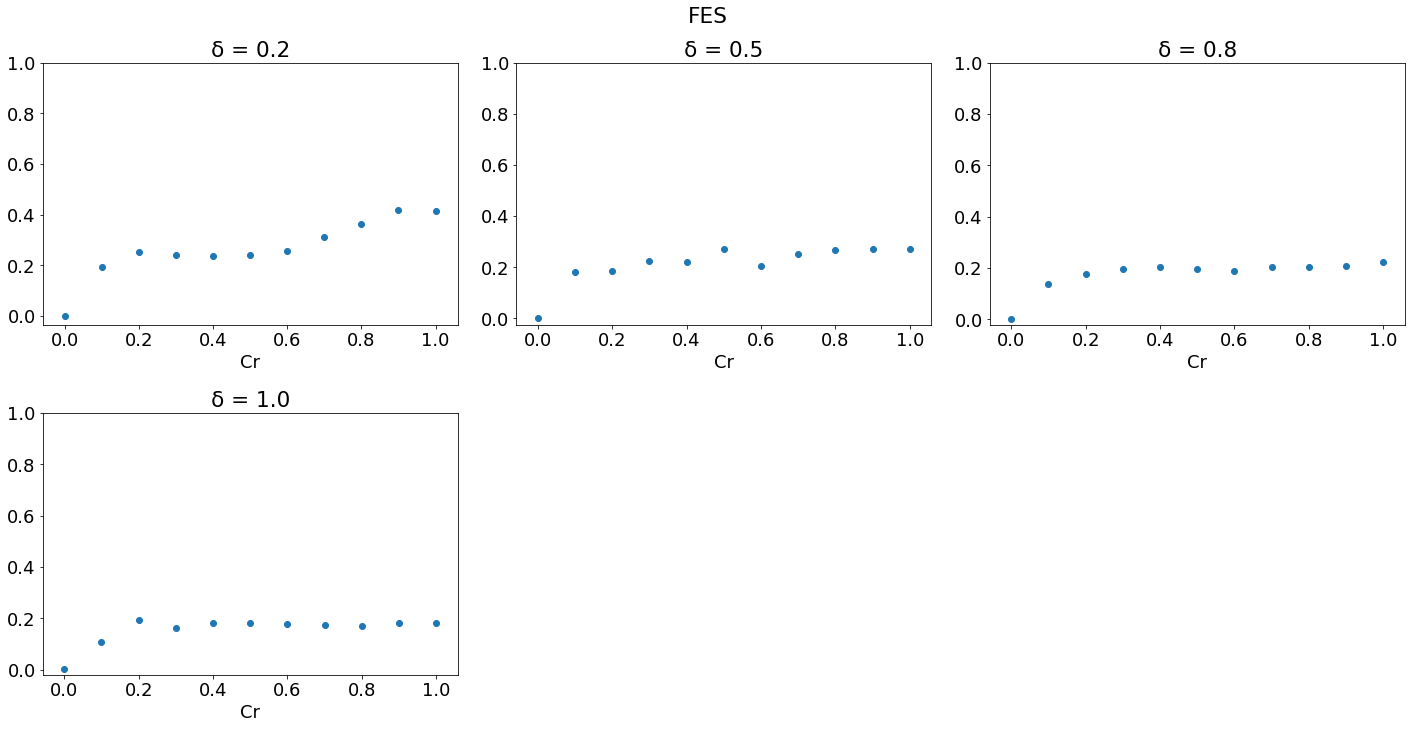

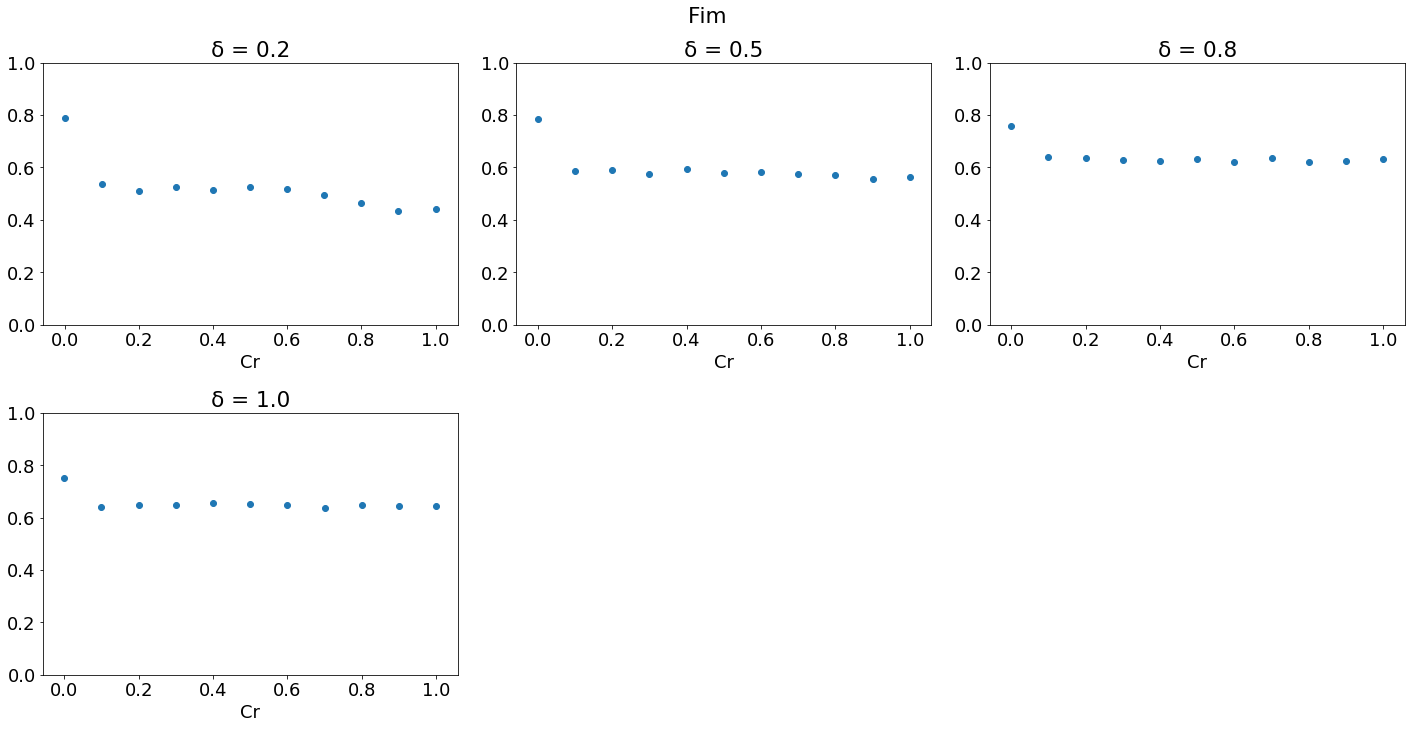

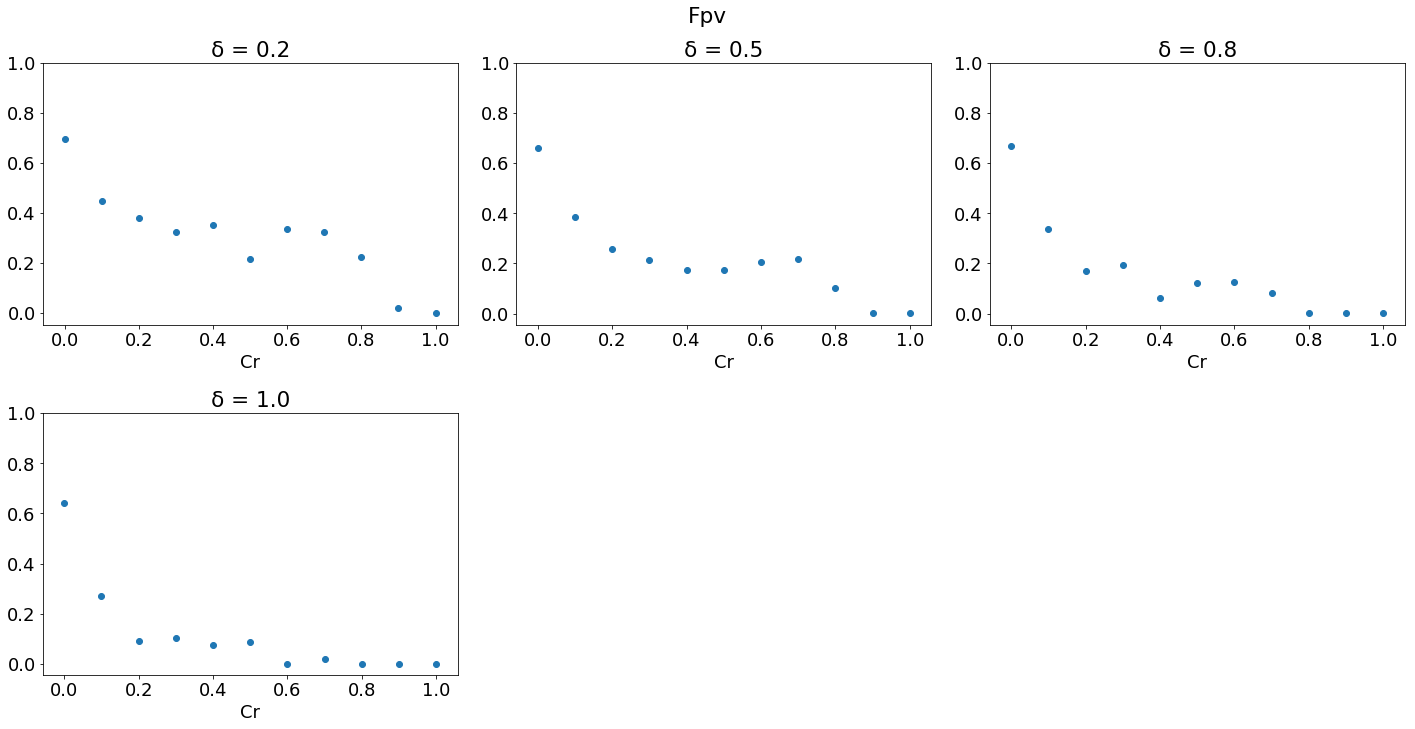

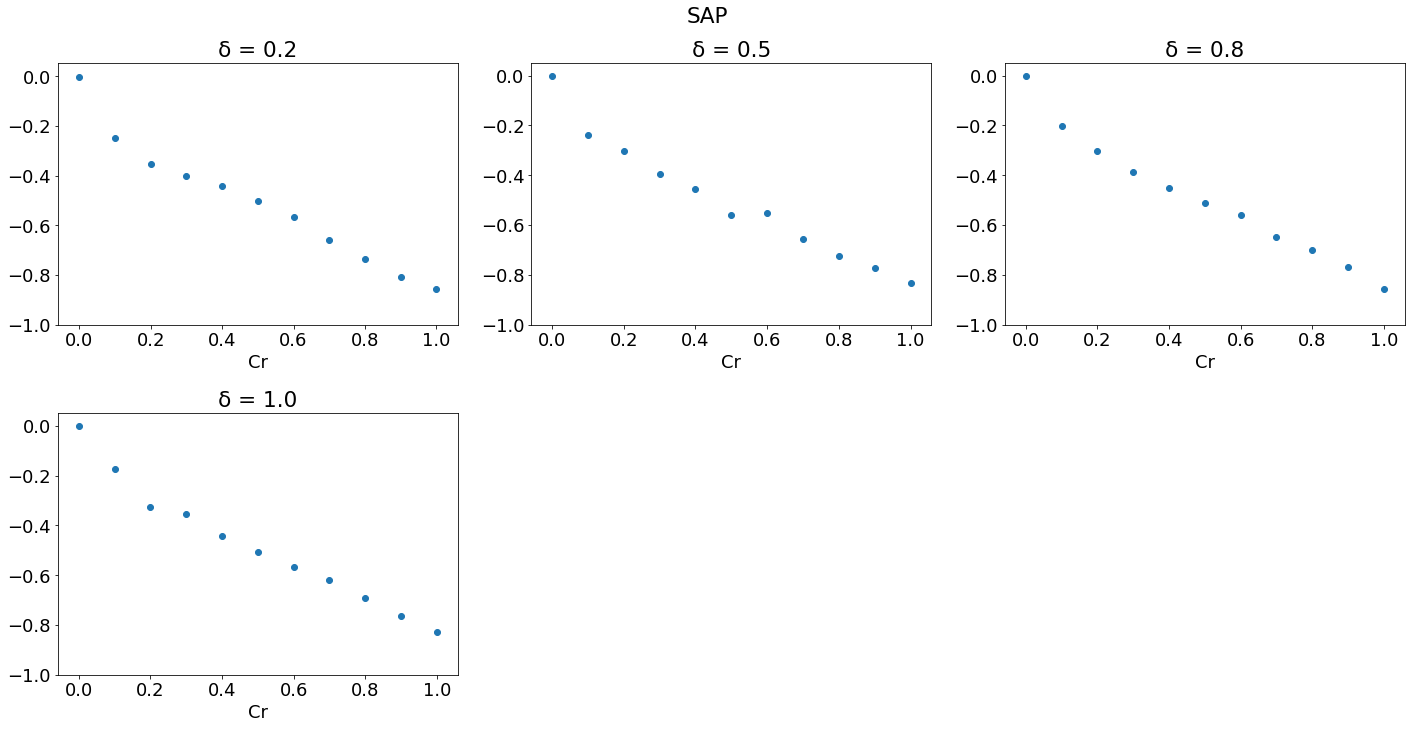

In [20]:
various_delta_plot("FES", save=True)
various_delta_plot("Fim", save=True)
various_delta_plot("Fpv", save=True)
various_delta_plot("SAP", save=True)

In [ ]:
# あるCr-δの組み合わせで100シーズン分計算したときの各Fractionの時間変化
df_list = [pd.read_csv(f"result/time_series/time_series_delta_0.2_cr_0.8_season_{season}.csv") for season in range(1, 101)]
concatted_df = pd.concat(df_list)
concatted_df = concatted_df.reset_index(drop=True)

fig = plt.figure(figsize=(40, 50))
plt.rcParams["font.size"] = 20
for index, value in enumerate(["fs", "fim", "fi", "fr", "IoverIM"]):
    ax = fig.add_subplot(5, 1, index+1)
    ax.plot(concatted_df[value])
    ax.set_title(value)
    ax.set_xlim([0, len(concatted_df)])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("Timestep")
    plt.tight_layout()

#fig.savefig("result/time_series/time_series_delta_0.2_cr_0.8_100season.png")
plt.show()

In [ ]:
# 最後のシーズンのみ
last_season = pd.read_csv("result/time_series/time_series_delta_0.2_cr_0.8_season_100.csv")
plt.rcParams["font.size"] = 20
last_season.plot(figsize=(12, 8), xlim=(0, len(last_season)), ylim=(0, 1.0))
plt.savefig("result/time_series/delta_0.2_cr_0.8_season_100.png")